# Genetic algorithm for art generation

Gleb Petrakov, 2019
Innopolis University

---

In [ ]:
!pip3 install opencv-python numpy matplotlib scipy ipympl

# Uncomment if you are running in a cloud environment to ensure libraries are installed
#!apt install -y libsm6 libxext6 libxrender1

In [1]:
import os
import cv2
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import argparse

In [2]:
BLUR_MASK_DIMENSION = 3
BLUR_MASK = np.ones(
    (BLUR_MASK_DIMENSION, 
     BLUR_MASK_DIMENSION),
    np.float32) / BLUR_MASK_DIMENSION**2
RESULT_DIRECTORY = 'result'

# Input image

In [3]:
class Input:
    IMAGE = np.zeros((512, 512, 3), dtype=np.float)
    IMAGE_PATH = None
    
    @staticmethod
    def init(image_path):
        Input.IMAGE_PATH = image_path
        Input.IMAGE = cv2.cvtColor(
            cv2.imread(image_path), 
            cv2.COLOR_BGR2RGB) / 255

# Chromosome

In [4]:
class Chromosome:

    def __init__(self, shapes_generated, shape_size, baseimg=None):
        self.shapes_generated = shapes_generated
        self.shape_size = shape_size
        
        self.image = self.init_image()
        if baseimg is not None:
            self.image = baseimg

        points = self.generate_points(self.shapes_generated)
        colors = self.generate_colors(self.shapes_generated)

        self.generate_image(points=points,
                           colors=colors)

    def init_image(self):
        mean_color = np.mean(Input.IMAGE)
        return np.ones(Input.IMAGE.shape, dtype=np.float) * mean_color

    def generate_colors(self, shapes):
        return [Input.IMAGE
                [np.random.randint(0, Input.IMAGE.shape[0])]
                [np.random.randint(0, Input.IMAGE.shape[1])] 
                for _ in range(shapes)]

    def generate_points(self, shapes):
        points = []
        for _ in range(shapes):
            x_base = np.random.randint(0, self.image.shape[1])
            y_base = np.random.randint(0, self.image.shape[0])
            shift = np.random.randint(0, self.shape_size)
            x_points = np.array(
                [x_base, x_base + shift, x_base, x_base - shift])
            y_points = np.array(
                [y_base + shift, y_base, y_base - shift, y_base])
            points.append(np.stack([x_points, y_points], axis=1))
        points = np.array(points)
        return points

    def generate_image(self, points, colors):
        for (points, color) in zip(points, colors):
            opacity = np.random.random()
            new_image = self.image.copy()
            new_image = cv2.fillPoly(new_image, [points], color[:3])
            self.image = cv2.addWeighted(
                new_image, opacity, self.image, 1 - opacity, 0)

# GA generator

In [5]:
class GeneticGenerator:

    def __init__(self, chr_shape_count, chr_shape_size, population_size):
        self.chr_shape_count = chr_shape_count
        self.chr_shape_size = chr_shape_size
        self.population_size = population_size
        
        self.population = self.generate_population(None, population_size)
        self.error = None
        self.error_history = []

    def generate_population(self, baseimg, pop_size):
        population = [Chromosome(self.chr_shape_count, 
                                 self.chr_shape_size, baseimg=baseimg) for _ in range(pop_size)]
        return population

    def population_error(self, chromosomes):
        ind_imgs = np.array([i.image for i in chromosomes])
        squared_error = (ind_imgs - Input.IMAGE)**2
        min_squared_error = squared_error / np.prod(Input.IMAGE.shape)
        min_squared_error = np.sum(min_squared_error, axis=(1, 2, 3))
        self.error = np.mean(min_squared_error)
        self.error_history.append(self.error)
        return min_squared_error
    
    def select_best_chromosome(self, chromosomes):
        mse = self.population_error(chromosomes)
        sorted_inds = [x[1] for x in sorted(
            zip(mse, chromosomes), key=lambda x: x[0])]  # TODO Rewrite
        return sorted_inds[0]
    
    def perform_selection(self):
        best_chromosome = self.select_best_chromosome(self.population)
        #best_chromosome.image = cv2.filter2D(best_chromosome.image, -1, BLUR_MASK)
        self.population = self.generate_population(best_chromosome.image, self.population_size)

# GA executor

In [6]:
class Main:
    
    def __init__(self, 
                 chr_shape_count=20, 
                 chr_shape_size=80, 
                 population_size=10,
                 epochs=1000,
                 splits=5):
        
        self.epochs = epochs
        self.splits = splits
        
        self.ga = GeneticGenerator(chr_shape_count, chr_shape_size, population_size)
        
        self.plt_figure = self.init_figure()
        
    def init_figure(self):
        
        fig = plt.figure(constrained_layout=True, figsize=(10, 10))
        gs0 = gridspec.GridSpec(2, 1, figure=fig)

        gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])

        self.ax1 = fig.add_subplot(gs1[0])
        self.ax1.set_title('Original image')
        self.ax1.axes.get_yaxis().set_visible(False)
        self.ax1.axes.get_xaxis().set_visible(False)

        self.ax2 = fig.add_subplot(gs1[1])
        self.ax2.set_title('Generated image')
        self.ax2.axes.get_yaxis().set_visible(False)
        self.ax2.axes.get_xaxis().set_visible(False)

        gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1])
        
        self.ax3 = fig.add_subplot(gs2[0], xlabel='Epoch', ylabel="Error")
        self.ax3.set_xlim([0, self.epochs])
        
        return fig
    
    def update_figure(self):
        self.ax1.imshow(Input.IMAGE)
        self.ax2.imshow(self.ga.select_best_chromosome(self.ga.population).image)
        self.ax3.plot(self.ga.error_history, color='blue')
        
        self.plt_figure.canvas.draw()
        
    def change_parameters(self, 
                          chr_shape_count=None, 
                          chr_shape_size=None, 
                          population_size=None):
        if chr_shape_count is not None:
            self.ga.chr_shape_count = chr_shape_count
        if chr_shape_size is not None:
            self.ga.chr_shape_size = chr_shape_size
        if population_size is not None:
            self.ga.population_size = population_size
            
    def autorun(self):  
        for split in range(self.splits):
            self.iterate(int(self.epochs / self.splits))
            epochs_processed = int((self.epochs / self.splits) * (split + 1))
            cv2.imwrite('result/epoch{}.png'.format(str(epochs_processed).zfill(len(str(self.epochs)))), 
                        (self.ga.select_best_chromosome(self.ga.population).image[...,::-1] * 255).astype(np.uint8))
            #printf('Slice {} completed. {} epochs out of {}.\n'.format(split + 1, epochs_processed, self.epochs))
        
        self.update_figure()
        final_image = cv2.filter2D(self.ga.select_best_chromosome(self.ga.population).image, -1, BLUR_MASK)
        cv2.imwrite('result/final.png', (final_image[...,::-1] * 255).astype(np.uint8))
        self.ax2.imshow(final_image)
        self.plt_figure.savefig("result/stats.png")
        
    def iterate(self, epochs):
        epochs = int(epochs)
        for _ in range(epochs):
            self.ga.perform_selection()
            self.update_figure()

# Command line

<IPython.core.display.Javascript object>


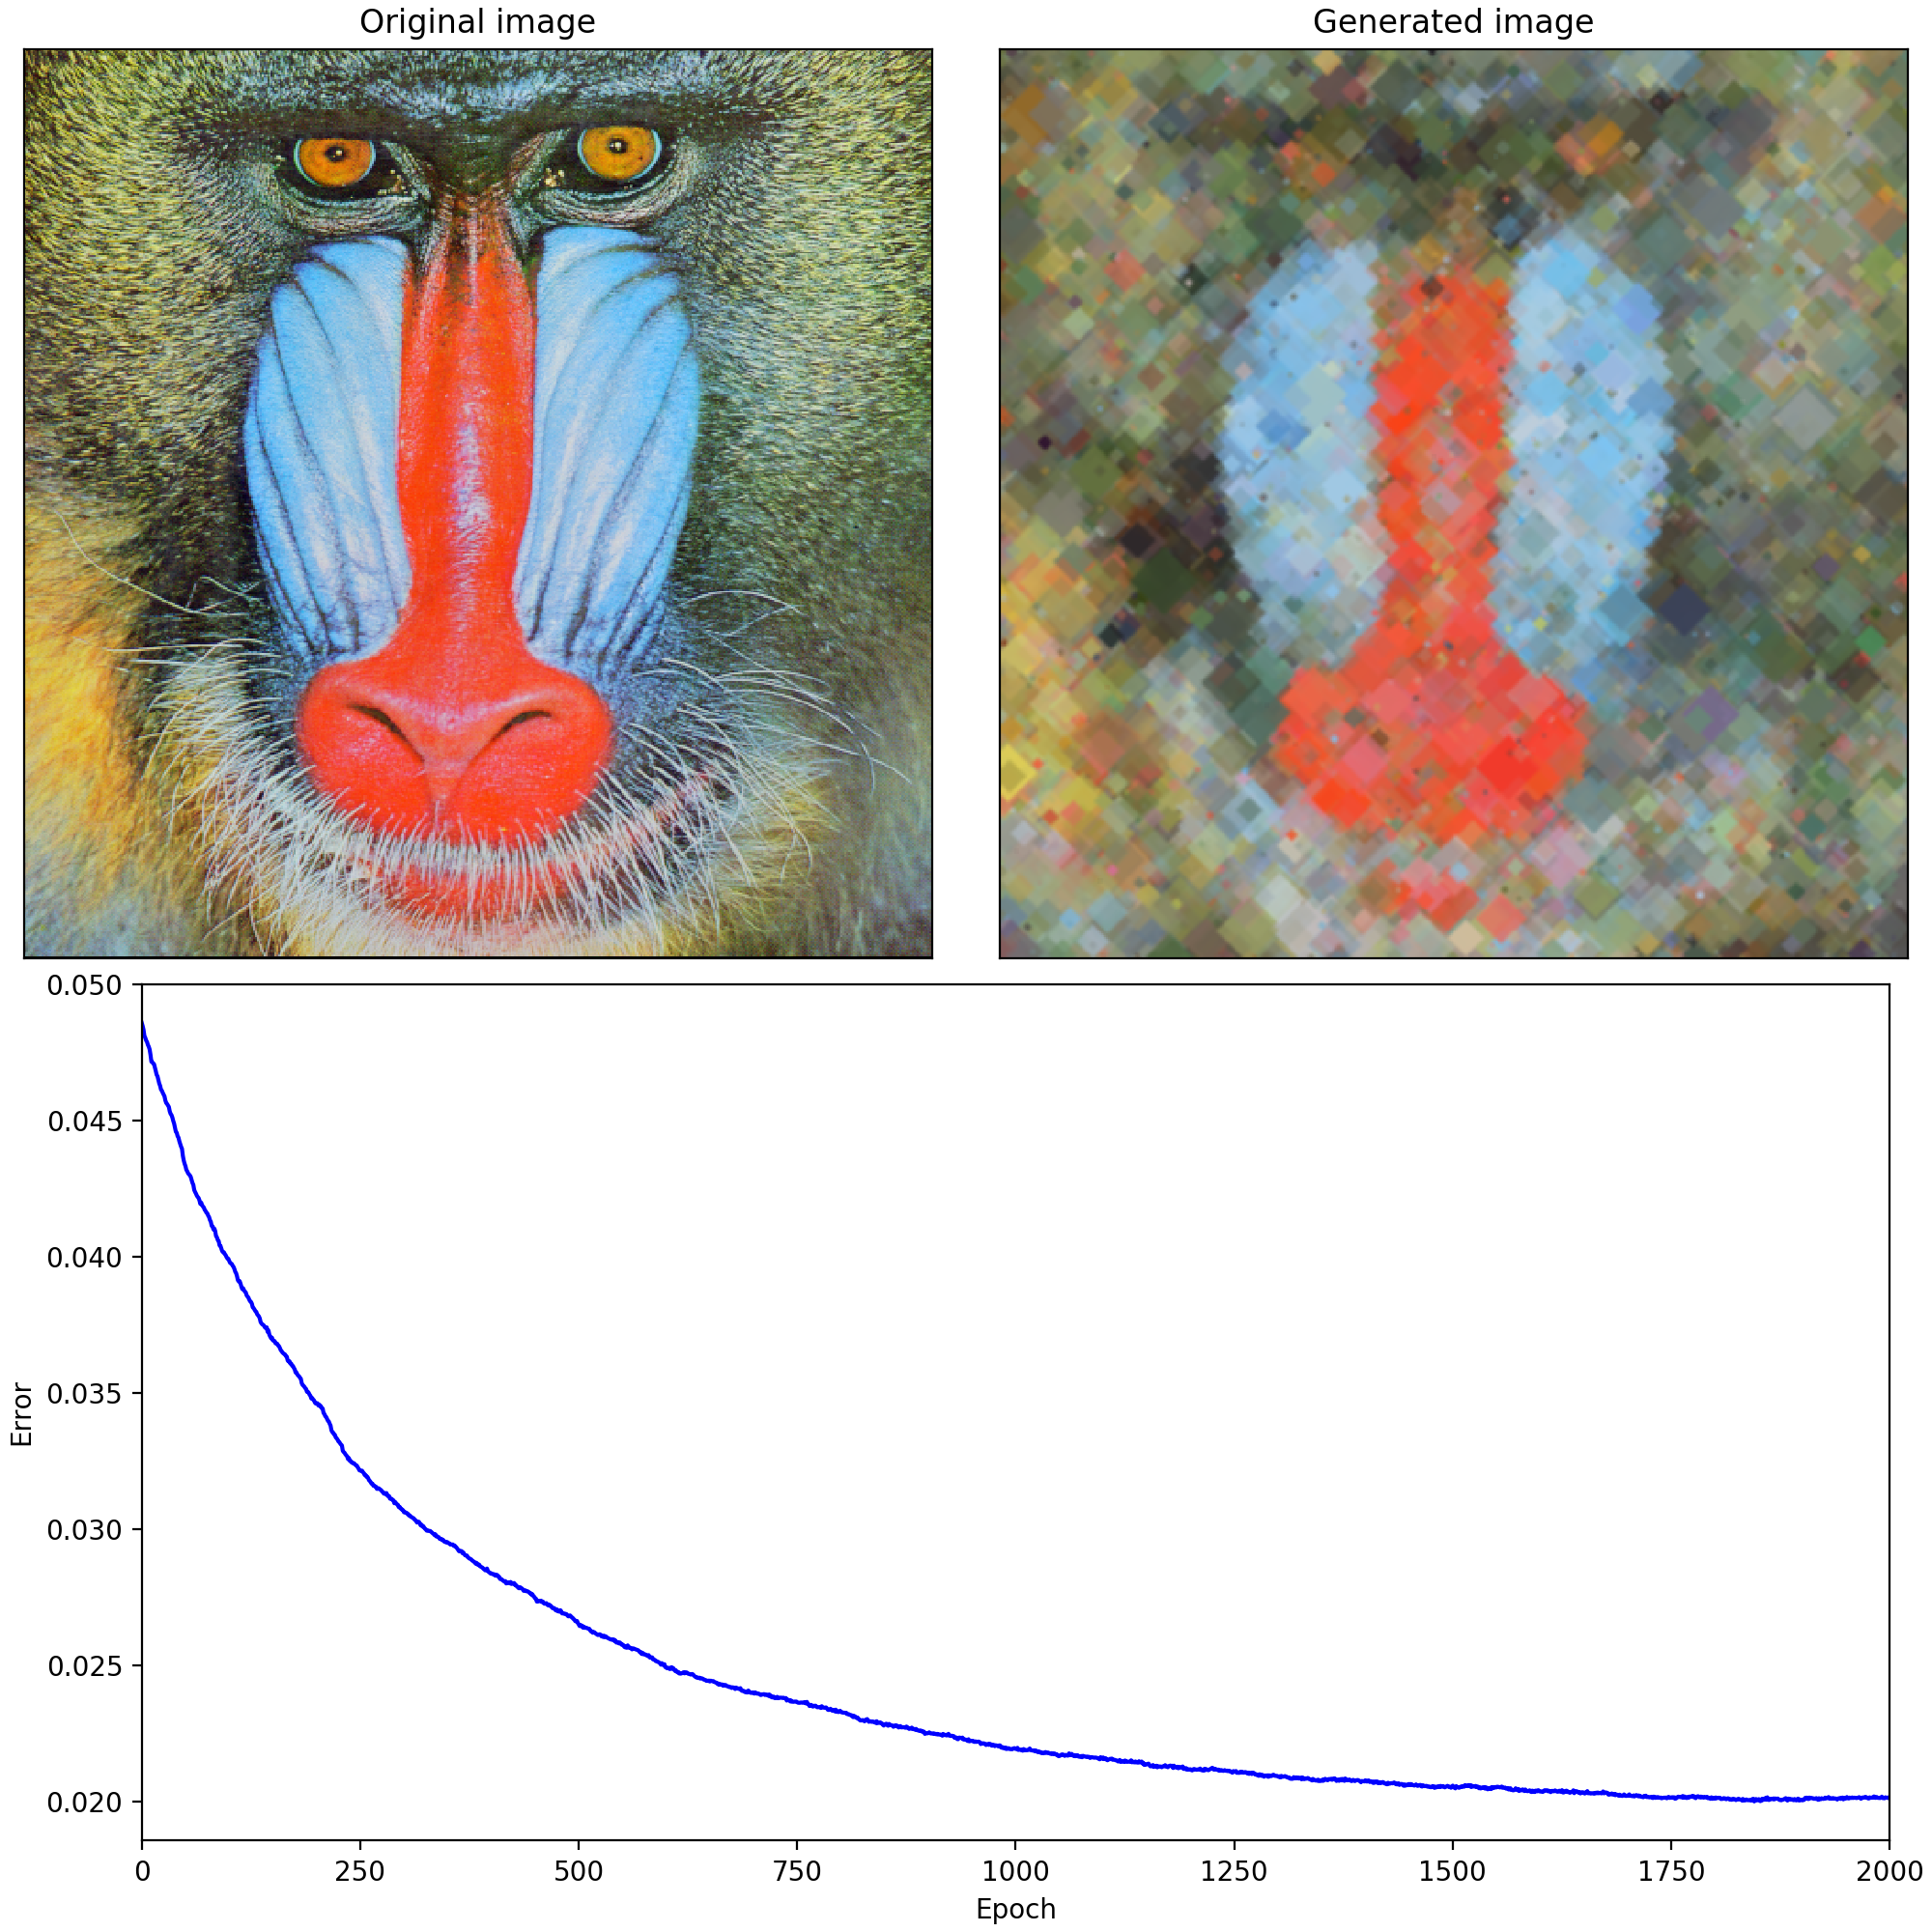

In [7]:
if __name__=='__main__':
    
    parser = argparse.ArgumentParser(
    description="Genetic algorithm image generating tool\nGleb Petrakov, 2019")
    parser.add_argument("--shape-count", type=int, action="store",
                        default=5,
                        dest='arg_shape_count', 
                        help="How much shapes does a chromosome contain")
    parser.add_argument("--shape-size", type=int, action="store",
                        default=20,
                        dest='arg_shape_size', 
                        help="How big may shapes be generated in a chromosome")
    parser.add_argument("--population-size", type=int, action="store",
                        default=35,
                        dest='arg_population_size', 
                        help="What is the count of chromosomes in a one population")
    parser.add_argument("--epochs", type=int, action="store",
                        default=2000,
                        dest='arg_epochs', 
                        help="How many times a population will be mutated")
    parser.add_argument("--splits", type=int, action="store",
                        default=10,
                        dest='arg_splits', 
                        help="How many times the algorithm should shrink its exploring rate")
    parser.add_argument("--image", type=str, action="store",
                        required=True,
                        dest='arg_image', 
                        help="Base image path")
    options = parser.parse_args(['--image', 'assets/primate.png'])
    
    Input.init(options.arg_image)
    
    if not os.path.exists(RESULT_DIRECTORY):
        os.makedirs(RESULT_DIRECTORY)

    a = Main(chr_shape_count=options.arg_shape_count, 
                 chr_shape_size=options.arg_shape_size, 
                 population_size=options.arg_population_size,
                 epochs=options.arg_epochs,
                 splits=options.arg_splits)

In [8]:
    a.autorun()